#**Sentiment analysis with BERT**




**What is BERT?**

The Bidirectional Encoder Representations from Transformers, also called BERT, represent a machine learning model used for NLP tasks. One distinguishing characteristic of this model is the ability to learn information from both the left and right sides of a token's context. Applying this bidirectional training can give a deeper sense of language context. Unlike other models that use the same method, Bert makes use of Transformer, an attention mechanism that learns contextual relations between words in a text. A transformer embeds lists of tokens into vectors, and then they are processed inside the network.

The base model used here is a 12-layer, 768-hidden, 12-heads, 110M parameter neural network architecture.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Check for gpu avaibility
import torch

if torch.cuda.is_available():
  print("Available")   
  device = torch.device("cuda")
else:
  
  print("NOT Available, using cpu instead")
  device = torch.device("cpu")

Available


In [3]:
#Install Hugging Face Library to use BERT
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 94.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 113.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 24.0 MB/s eta 0:00:00


In [4]:
import nltk
import time
import numpy as np
from nltk.corpus import movie_reviews
from nltk.corpus import subjectivity

from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import transformers as ppb

import time
import datetime
from transformers import get_linear_schedule_with_warmup
import random
from transformers import BertForSequenceClassification, AdamW, BertConfig
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

from torch.nn import functional as F
import os
from sklearn.metrics import accuracy_score 

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report

nltk.download('stopwords')
nltk.download('punkt')

#for polarity classification
nltk.download('movie_reviews')

#for subjectivity classification
nltk.download('subjectivity')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
[nltk_data] Downloading package subjectivity to /root/nltk_data...
[nltk_data]   Unzipping corpora/subjectivity.zip.


True

#**Loading Datasets**
There are 2 tasks that need to be performed:

*   Subjectivity detection: subjectivity dataset from nltk
*   Polarity classification: movie reviews dataset from nltk

For the subjectivity dataset a list of sentence is created, meanwhile, the movie review dataset is structured by a list of sentence for each review.



**No preprocessing implies**

One benefit of BERT, as mentioned above, is to learn the representation of the tokens in context, which means that stopwords and punctuation can give a different weight to the sentence's meaning.
Therefore, filtering the text would just imply removing context, which BERT could have used to get better results.

In [5]:
# flatten and join together tokens
def word2str(doc):
    return " ".join([w  for w in doc])

In [6]:
movie_no_label = []

#-----------MOVIE REVIEWS------------
#prepare dataset by splitting review into individual sentences
for label in movie_reviews.categories():
    #check the order of the categories
    print(label)
    for fileid in movie_reviews.fileids(label):
        #subdivide each review into sentences
        dc = [word2str(d) for d in (movie_reviews.sents(fileid))]
        movie_no_label.append(dc)

#polarity labels 
labels_pol = [0 for i in range(0,1000)] + [1 for i in range(1000,2000)]

#-----------SUBJECTIVITY------------
#list of sentences
obj_sents = [word2str(sent) for sent in subjectivity.sents(categories='obj')]
subj_sents = [word2str(sent) for sent in subjectivity.sents(categories='subj')]
subject = obj_sents + subj_sents
#subjectivity labels
labels_subj = [0 for i in range(len(obj_sents))] + [1 for i in range(len(subj_sents))]

print("------------------------------------------------------------------")

#see the results
print(movie_no_label[0])
print(subject[0])


neg
pos
------------------------------------------------------------------
['plot : two teen couples go to a church party , drink and then drive .', 'they get into an accident .', 'one of the guys dies , but his girlfriend continues to see him in her life , and has nightmares .', "what ' s the deal ?", 'watch the movie and " sorta " find out .', '. . critique : a mind - fuck movie for the teen generation that touches on a very cool idea , but presents it in a very bad package .', "which is what makes this review an even harder one to write , since i generally applaud films which attempt to break the mold , mess with your head and such ( lost highway & memento ) , but there are good and bad ways of making all types of films , and these folks just didn ' t snag this one correctly .", 'they seem to have taken this pretty neat concept , but executed it terribly .', 'so what are the problems with the movie ?', "well , its main problem is that it ' s simply too jumbled .", 'it starts off " n

#**BERT Tokenizer**
The tokenization process is performed by the tokenizer included with Bert. It requires some important steps to convert perfectly the tokens into ids that will be consequently used in the training phase:


*   Add special tokens at the start and the end of the sentence ([CLS] + sentence + [SEP])
*   Pad and truncate a sentence to a fixed given length
*   Create an attention mask to distinguish between real token and pad 



In [7]:
#import Bert model
print('Loading BERT tokenizer...')

model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer,'bert-base-uncased')

#use BERT tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights, do_lower_case=True)
model = model_class.from_pretrained(pretrained_weights)

Loading BERT tokenizer...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
#use the .encode() method that will perform the tokenization as mentioned before
def bert_encoder(max_len, sent, tokenizer):

  encoded_sent = tokenizer.encode(
                          sent,                   
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                          max_length = max_len,          # Truncate sentence, not included padding
                          truncation = True
                    )
  return encoded_sent

#give a list of sentences to be elaborate
def preparing_data_for_bert(list_sents, max_len,tokenizer):
  sent_ids = []
  print("Encoding...")
  for sent in list_sents:
    sent_ids.append(bert_encoder(max_len,sent,tokenizer))

#padding each sentence by adding 0 
  print('\nPadding and truncating all sentences to %d values...' % max_len)
  sents_ids = pad_sequences(sent_ids, maxlen=max_len, dtype="long",     
                          value=0, truncating="post", padding="post")
  
  print("Creating attention masks for all sentences...")
  attention_masks = []

  #vector of 0 and 1 where ids > 0, after padding
  for sent in sents_ids:
    att_mask = [int(token_id > 0) for token_id in sent]
    attention_masks.append(att_mask)
  print("\nDone!\n")

  return attention_masks, sents_ids

#function to be feed with all the reviews 
def encoding_document_sents(sent_list, max_len, tokenizer):
  max_len = max_len
  all_masks = []
  all_ids = []

  #we will gonna obtain a list of sentence for each review 
  start_time = time.time()
  i = 0
  for sents in sent_list:
    print("------------------review no.{}-----------------------\n".format(i))
    att, ids = preparing_data_for_bert(sents, max_len, tokenizer)
    all_masks.append(att)
    all_ids.append(ids)
    i+=1
  print("------------------- %s seconds ------------------------" % (time.time() - start_time))

  print(len(all_ids))
  return all_masks, all_ids

In [9]:
#Run the tokenization process for both datasets

################ SUBJECTIVITY dataset ################
print("Subjectivity dataset")
max_len = 64
att_masks_subj, subj_ids = preparing_data_for_bert(subject, max_len,tokenizer)

print("Movie review dataset")
################ MOVIE dataset ################
max_len = 64
all_masks, all_ids = encoding_document_sents(movie_no_label, max_len, tokenizer)


Output streaming troncato alle ultime 5000 righe.

Done!

------------------review no.1445-----------------------

Encoding...

Padding and truncating all sentences to 64 values...
Creating attention masks for all sentences...

Done!

------------------review no.1446-----------------------

Encoding...

Padding and truncating all sentences to 64 values...
Creating attention masks for all sentences...

Done!

------------------review no.1447-----------------------

Encoding...

Padding and truncating all sentences to 64 values...
Creating attention masks for all sentences...

Done!

------------------review no.1448-----------------------

Encoding...

Padding and truncating all sentences to 64 values...
Creating attention masks for all sentences...

Done!

------------------review no.1449-----------------------

Encoding...

Padding and truncating all sentences to 64 values...
Creating attention masks for all sentences...

Done!

------------------review no.1450-----------------------



#**Subjectivity detection on sentence-level**
The subjectivity dataset will be use to train Bert. It will detect if a sentence is objective or subjective, then the model will be evaluate on the movie reviews dataset to remove all the objective sentences.

In [10]:
def prepare_dataset(ids, att_masks, labels, sampler_subj ,batch_size):

  x = ids
  y = labels
  masks = att_masks

  # Convert into torch tensors
  x = torch.tensor(x).to(device)
  y = torch.tensor(y).to(device)
  masks = torch.tensor(masks).to(device)


  # Create a Tensor dataset 
  data = TensorDataset(x, masks, y)
  
  #Use Dataloader to manage batches
  if (sampler_subj):
    #pick random samples inside the batch
    dataloader = DataLoader(data,sampler=RandomSampler(data), batch_size=batch_size)
  else:
    dataloader = DataLoader(data, batch_size=batch_size) 

  return dataloader

#function to format time from seconds to hh:mm:ss
def format_time(elapsed):
  return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [11]:
#function to save the model inside google drive
def saving(model, dir):

  # Automatically create output directory if needed
  if not os.path.exists(dir):
      os.makedirs(dir)

  print("Saving model to %s" % dir)
  model_to_save = model.module if hasattr(model, 'module') else model 
  model_to_save.save_pretrained(dir)

##Train & Test Bert for Subjectivity detection task


1.   Train on the whole subjectivity dataset
2.   Test on the whole movie reviews dataset 

The movie review dataset is defined by reviews represented as list of sentences , this will be handy for removing the sentences that are objectives from each review in the next step.



In [12]:
#function to train bert
def bert_training_model(N_EPOCHS, total_steps, model, train_dataloader, optimizer, name, scheduler):

    # Set the seed value all over the place to make this reproducible.
    seed_val = 42

    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

    # Store the average loss after each epoch
    loss_values = []

    print("Start training\n")

    #cleaning cache to free some memory...
    torch.cuda.empty_cache()

    for epoch in range(0, N_EPOCHS):
        start_time = time.time()
        print('\n------------ Epoch {} / {} ------------'.format(epoch + 1, N_EPOCHS))

        # Reset the total loss for this epoch.
        epoch_loss = 0

        #train mode
        model.train()

        print("Training for each batch...")

        for step, batch in enumerate(train_dataloader):
            
            #extract ids, masks and labels from the batch
            batch_input_ids = batch[0].to(device)
            batch_mask = batch[1].to(device)
            batch_labels = batch[2].to(device)

            # why zero_grad ->(source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
            model.zero_grad()        

            outputs = model(batch_input_ids, attention_mask=batch_mask,token_type_ids=None, labels=batch_labels)
            
            # loss value out of the tuple.
            loss = outputs[0]

            # Accumulate the training loss over all of the batches
            epoch_loss += loss.item()

            # Perform a backward pass to calculate the gradients.
            loss.backward()

            # To prevent the "exploding gradients" problem
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and take a step using the computed gradient.
            optimizer.step()

            # Update the learning rate.
            scheduler.step()

        # Calculate the average loss over the training data.
        avg_loss = epoch_loss / len(train_dataloader)            
        
        # Store the loss value for plotting the learning curve.
        loss_values.append(avg_loss)

        print('\n------------ Time per epoch: {:} ------------\n'.format( format_time(time.time() - start_time) ) )

        print("  Average training loss: {0:.2f}".format(avg_loss) )

    print("\nTraining done")

    saving(model, dir = '/content/drive/My Drive/Sentiment_analysis/{}/'.format(name))
    print("Model saved")
    return loss_values

In [13]:
#function to plot the loss curve
def loss_plot(loss_values):
  sns.set(style='darkgrid')

  # Increase the plot size and font size.
  sns.set(font_scale=1.5)
  plt.rcParams["figure.figsize"] = (12,6)

  plt.plot(loss_values, 'b-o')

  plt.title("Training loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")

  plt.show()

The model is fine-tuned on the whole subjectivity dataset by performing a small amount of training steps on the pre-trained Bert

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Start training


------------ Epoch 1 / 4 ------------
Training for each batch...

------------ Time per epoch: 0:01:44 ------------

  Average training loss: 0.19

------------ Epoch 2 / 4 ------------
Training for each batch...

------------ Time per epoch: 0:01:47 ------------

  Average training loss: 0.08

------------ Epoch 3 / 4 ------------
Training for each batch...

------------ Time per epoch: 0:01:49 ------------

  Average training loss: 0.02

------------ Epoch 4 / 4 ------------
Training for each batch...

------------ Time per epoch: 0:01:49 ------------

  Average training loss: 0.01

Training done
Saving model to /content/drive/My Drive/Sentiment_analysis/bert_subj_scheduler/
Model saved


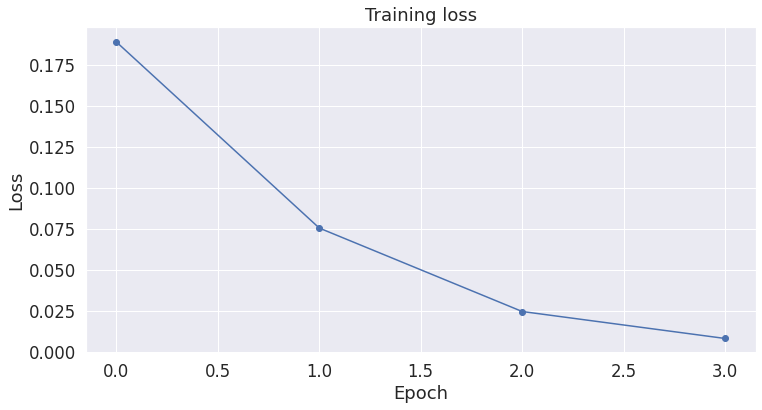

In [14]:
#name to indicate the directory where is saved the model
name = 'bert_subj_scheduler'
#name = 'bert_subj'

if not os.path.exists('/content/drive/My Drive/Sentiment_analysis/{}'.format(name)):

  #convert data in tensor then split in batches with dataloader
  #!!note that the dataset its already encoded

  #True -> randomsampler
  train_dataloader = prepare_dataset(subj_ids,att_masks_subj, labels_subj, True,32)

  #creating the model trainer
  model = BertForSequenceClassification.from_pretrained(
      "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
      num_labels = 2, # subj-obj  
      output_attentions = False, #returns attentions weights
      output_hidden_states = False, #returns all hidden-states
  )

  model.to(device)

  optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, eps=1e-08)
  # Number of training epochs. already pre-trained 
  N_EPOCHS = 4
  total_steps = len(train_dataloader) * N_EPOCHS

  scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

  #calling function for training
  loss_values=bert_training_model(N_EPOCHS, total_steps, model, train_dataloader, optimizer, name, scheduler)
  
  #print curve of loss
  loss_plot(loss_values)

else:
  print("model pretrained and fine-tuned already presents!")

The model will be evaluated on all the reviews at the sentence-level to keep only the subjective sentences.

In [15]:
# Prediction on test set, in this case its all the movie review dataset
def prediction(prediction_dataloader, model, n):

  #print no. of sentences
  print('Predicting subjectivity for {} test sentences...'.format(n))

  # Put model in evaluation mode
  model.eval()

  predictions = []

  # Predict 
  for batch in prediction_dataloader:
    batch = tuple(t.to(device) for t in batch)
    
    # Unpack the inputs from dataloader
    batch_input_ids, batch_mask, batch_labels = batch
    
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(batch_input_ids, token_type_ids=None, 
                        attention_mask=batch_mask)
        
    #The "logits" are the output values prior to applying an activation function like the softmax.
    logits = outputs.logits

    # Move logits to CPU, free some cuda
    logits = logits.detach().cpu().numpy()
    
    # Store predictions
    predictions.append(logits)
    
  print("\nDone")
  return predictions

##Subjectivity criterion
The sentences are defined as subjective if their probability score is beyond a specific threshold. In this case is set to 0.60 to remove also the weakest sentences that were score as subjective.

To define the probability of the predicted label of the sentence a sigmoid is performed to the logit level of the network

In [16]:
#function to obtain the scores and the predictions
def flat_preds(preds):

  # The predictions are a 2-column ndarray (one column for "0" and one column for "1") 

  # assembly all the batches together
  predictions = [item for sublist in preds for item in sublist]
  #convert logits to predictions
  flat_predictions = np.argmax(predictions, axis=1).flatten()

  #convert logits to probability value
  score = [convert_score(item) for sublist in preds for item in sublist] 
  
  return flat_predictions, score

#convert logit into score
def convert_score(logits):

  #Logit is a function that maps probabilities ([0, 1]) to R ((-inf, inf))
  #is defined as the output of a neuron without applying activation function -> logit = w*x + b
  logits = np.array(logits)

  # convert logit score to torch array
  torch_logits = torch.from_numpy(logits)

  # get probabilities using sigmoid from logit score and convert it to numpy array
  #our tensor [obj, subj] -> [1] take second column = subj class
  #sigmoid convert the [-inf, inf] to [0, 1] 
  m = torch.nn.Sigmoid()
  probabilities_scores = m(torch_logits).numpy()[1]
  
  return probabilities_scores

In [17]:
#subjectivity detection on a review example
# Load a trained model fine-tuned
dir = '/content/drive/My Drive/Sentiment_analysis/bert_subj_scheduler/'
#dir = '/content/drive/My Drive/Sentiment_analysis/bert_subj/'
model = BertForSequenceClassification.from_pretrained(dir).to(device)
print("Model loaded")

start_time = time.time()
new_movie_no_label = []
for i in range(len(all_ids)):

  #polarity dataloader define for each review
  pol_dataloader = prepare_dataset(all_ids[i], all_masks[i], np.ones(len(all_ids[i])), False,32)

  #evaluating subjectivity of each sentence
  predictions = prediction(pol_dataloader, model, len(all_ids[i]))

  # Combine the predictions for each batch into a single list of 0s -> obj and 1s -> subj
  flat_predictions, flat_scores = flat_preds(predictions)

  print("length: {}, prediction labels: {} ".format(len(flat_predictions),flat_predictions))

  #print probabilities for each sentence inside the review
  scores = [round(sc,3) for sc in flat_scores]
  print(scores)
  sents = []

  #consider the bordeline cases where 0.50<prob<0.60 as not subjective enough
  for j in range(len(movie_no_label[i])):
    if(scores[j] > 0.60):
      sents.append(movie_no_label[i][j])
  
  #buld a new dataset without the objective sentences
  new_movie_no_label.append(sents)

  print("-----------------------------no. {}-----------------------------------".format(i))

print('\n------------ Time score subjectivity: {:} ------------\n'.format( format_time(time.time() - start_time) ) )

print(len(new_movie_no_label))

Output streaming troncato alle ultime 5000 righe.

Done
length: 17, prediction labels: [1 1 1 1 1 1 0 0 1 1 1 1 0 1 1 1 1] 
[0.887, 0.967, 0.931, 0.952, 0.965, 0.962, 0.042, 0.136, 0.968, 0.971, 0.967, 0.744, 0.131, 0.978, 0.974, 0.831, 0.95]
-----------------------------no. 1213-----------------------------------
Predicting subjectivity for 26 test sentences...

Done
length: 26, prediction labels: [1 1 1 1 1 0 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1] 
[0.978, 0.978, 0.919, 0.878, 0.765, 0.044, 0.834, 0.968, 0.846, 0.951, 0.15, 0.03, 0.029, 0.024, 0.692, 0.977, 0.94, 0.897, 0.848, 0.973, 0.953, 0.961, 0.909, 0.977, 0.978, 0.972]
-----------------------------no. 1214-----------------------------------
Predicting subjectivity for 33 test sentences...

Done
length: 33, prediction labels: [0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1] 
[0.036, 0.023, 0.049, 0.931, 0.024, 0.028, 0.027, 0.022, 0.024, 0.025, 0.054, 0.025, 0.037, 0.971, 0.749, 0.978, 0.089, 0.092, 0.938, 0

In [18]:
#see number of sentences for each review
def plot_no_sents(dataset):

  plt.clf()

  #print graph with number of sentence per review
  len_sent = [len(sent) for sent in (dataset)]
  print(len(len_sent))

  plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})
  plt.bar(range(len(len_sent)), len_sent, color = ['red'])
  plt.gca().set(title='No. of sentence', xlabel='Reviews', ylabel='Number of sents in each review');

  plt.show()

2000


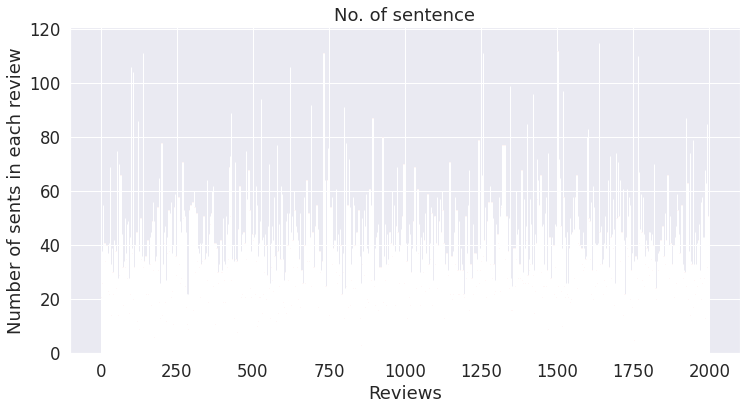

-------------------------------------------
2000


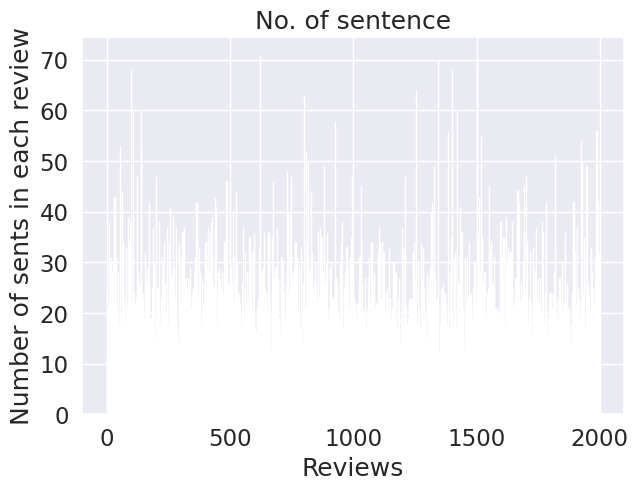

In [19]:
#-----------------before-----------------
plot_no_sents(movie_no_label)

print("-------------------------------------------")

#-----------------after-----------------
plot_no_sents(new_movie_no_label)

#**Polarity detection**

The Bert model is trained again, but in this case it's used to detect the positivity and negativity of a sentence.
To perform this task, the movie review dataset is split into a train set and a test set. The train set will be used as single sentences to be fed inside Bert; meanwhile, the test set will remain structured as it is. Each sentence of the test set will be evaluated separately, and the number of positive or negative sentences will define the predicted label of the review.





In [20]:
#Prepare train and test sets

#neg and pos equally divided into the two classes 
#train set -> 80%, test set -> 20%
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

#make it compatible with the Stratified
labels_pol = np.array(labels_pol)
new_movie_no_label = np.array(new_movie_no_label)

for train_index, test_index in sss.split(new_movie_no_label, labels_pol):
    train_inputs, test_inputs = new_movie_no_label[train_index], new_movie_no_label[test_index]
    train_labels, test_labels = labels_pol[train_index], labels_pol[test_index]

<ipython-input-20-d80317d64a31>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  new_movie_no_label = np.array(new_movie_no_label)


In [21]:
#transform train set into individual sentences 
train_sents = []
label = []
i = 0
for sents in train_inputs:
  for sent in sents:
    train_sents.append(sent)
    #assign at each sentece the label of their belonging review
    label.append(train_labels[i])
  i+=1

############ TRAIN DATASET ############
#create bert encoder for training set of each sentence separately
print("Train dataset encoding...")
max_len = 64
train_masks, train_ids = preparing_data_for_bert(train_sents, max_len,tokenizer)

print("---------------------------------------------")

############ TEST DATASET ############
#keep the sentences inside each review
print("Test dataset encoding...")
max_len = 64
all_masks_test, all_ids_test = encoding_document_sents(test_inputs, max_len, tokenizer)

Train dataset encoding...
Encoding...

Padding and truncating all sentences to 64 values...
Creating attention masks for all sentences...

Done!

---------------------------------------------
Test dataset encoding...
------------------review no.0-----------------------

Encoding...

Padding and truncating all sentences to 64 values...
Creating attention masks for all sentences...

Done!

------------------review no.1-----------------------

Encoding...

Padding and truncating all sentences to 64 values...
Creating attention masks for all sentences...

Done!

------------------review no.2-----------------------

Encoding...

Padding and truncating all sentences to 64 values...
Creating attention masks for all sentences...

Done!

------------------review no.3-----------------------

Encoding...

Padding and truncating all sentences to 64 values...
Creating attention masks for all sentences...

Done!

------------------review no.4-----------------------

Encoding...

Padding and truncati

##Train & Test Bert for Polarity classification task


*   Train performs on single sentences to detect negative or positive sentences
*   Test performs on single sentences for each review, then sum together to obtain the resulting predicted label.



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Start training


------------ Epoch 1 / 6 ------------
Training for each batch...

------------ Time per epoch: 0:05:20 ------------

  Average training loss: 0.59

------------ Epoch 2 / 6 ------------
Training for each batch...

------------ Time per epoch: 0:05:20 ------------

  Average training loss: 0.48

------------ Epoch 3 / 6 ------------
Training for each batch...

------------ Time per epoch: 0:05:20 ------------

  Average training loss: 0.39

------------ Epoch 4 / 6 ------------
Training for each batch...

------------ Time per epoch: 0:05:20 ------------

  Average training loss: 0.32

------------ Epoch 5 / 6 ------------
Training for each batch...

------------ Time per epoch: 0:05:20 ------------

  Average training loss: 0.26

------------ Epoch 6 / 6 ------------
Training for each batch...

------------ Time per epoch: 0:05:20 ------------

  Average training loss: 0.22

Training done
Saving model to /content/drive/My Drive/Sentiment_analysis/bert_pol_scheduler/
Mo

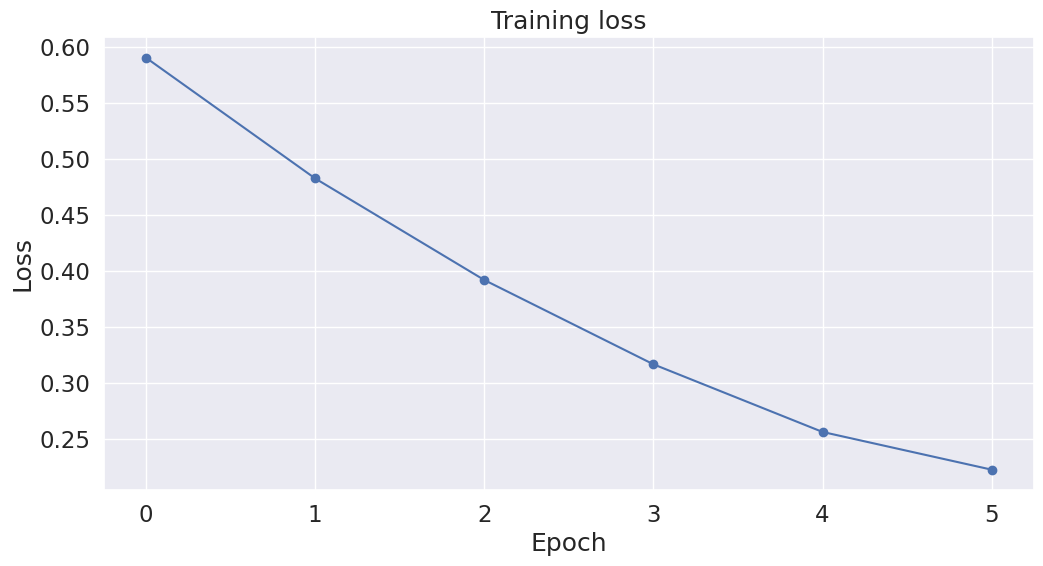

In [22]:
name = 'bert_pol_scheduler'
#name = 'bert_pol'
train_dataloader = prepare_dataset(train_ids,train_masks, label, True,32)
if not os.path.exists('/content/drive/My Drive/Sentiment_analysis/{}'.format(name)):

  #creating the model trainer
  model2 = BertForSequenceClassification.from_pretrained(
      "bert-base-uncased",
      num_labels = 2, # neg-pos  
      output_attentions = False, 
      output_hidden_states = False, 
  )

  model2.to(device)

  optimizer = torch.optim.Adam(model2.parameters(), lr=1e-5, eps=1e-08)
  N_EPOCHS = 6
  total_steps = len(train_dataloader) * N_EPOCHS

  scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

  loss_values2 = bert_training_model(N_EPOCHS, total_steps, model2, train_dataloader, optimizer, name, scheduler)

  #print curve of loss
  loss_plot(loss_values2)
else:
  print("model pretrained and fine-tuned already presents!")

##Polarity criterion
One review is assign to a pos-label if the sum of all the sentences predicted as positive is more than half the total predicted sentences.

In [23]:
# Load a trained model fine-tuned
dir = '/content/drive/My Drive/Sentiment_analysis/bert_pol_scheduler'
#dir = '/content/drive/My Drive/Sentiment_analysis/bert_pol'
model2 = BertForSequenceClassification.from_pretrained(dir).to(device)
print("Model loaded")

start_time = time.time()
pred_label = []
for i in range(len(all_ids_test)):

  pol_dataloader = prepare_dataset(all_ids_test[i], all_masks_test[i], test_labels[i]*np.ones(len(all_ids_test[i])), False,32)

  #evaluating polarity of each sentence
  predictions = prediction(pol_dataloader, model2, len(all_ids_test[i]))
  
  flat_predictions, flat_scores = flat_preds(predictions)

  print("length: {}, prediction labels: {} ".format(len(flat_predictions),flat_predictions))
  print("prediction values: {} ".format(flat_scores))
  
  #Polarity score
  #count number of positive sentences inside a review, if more than half review then label is positive
  count = 0
  for j in flat_predictions:
    if j == 1 :
      count += 1
  if count > (len(flat_predictions)/2):
    #1 -> pos
    pred_label.append(1)
  else:
    #0 -> neg
    pred_label.append(0)

  print("----------------------------no.{}----------------------------------".format(i))

print('\n------------ Time score polarity: {:} ------------\n'.format( format_time(time.time() - start_time) ) )

Model loaded
Predicting subjectivity for 19 test sentences...

Done
length: 19, prediction labels: [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0] 
prediction values: [0.0983064, 0.053948954, 0.06810909, 0.061131664, 0.41028762, 0.05953295, 0.047814246, 0.5770548, 0.1796604, 0.20984459, 0.07224926, 0.20714016, 0.06749372, 0.17175882, 0.3095989, 0.6104813, 0.12388263, 0.112173125, 0.1749909] 
----------------------------no.0----------------------------------
Predicting subjectivity for 19 test sentences...

Done
length: 19, prediction labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0] 
prediction values: [0.21311416, 0.23952043, 0.26419222, 0.31234768, 0.07446936, 0.42379677, 0.21414702, 0.09322757, 0.051268555, 0.1778905, 0.07881453, 0.2631225, 0.054952666, 0.8091064, 0.16460618, 0.073543176, 0.1582767, 0.039110713, 0.052359466] 
----------------------------no.1----------------------------------
Predicting subjectivity for 6 test sentences...

Done
length: 6, prediction labels: [1 1 1 1 1 1] 
pre

##Results

In [24]:
#Print the final report and the accuracy 
from sklearn.metrics import confusion_matrix

print("Accuracy document-level: {}%".format(accuracy_score(test_labels, pred_label)*100))
print("--------------------------------------------------")
print(classification_report(y_true=test_labels, y_pred=pred_label))
print("--------------------------------------------------")
print("Confunsion matrix")
confusion_matrix(y_true=test_labels, y_pred=pred_label)

Accuracy document-level: 91.25%
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.94      0.91       200
           1       0.93      0.89      0.91       200

    accuracy                           0.91       400
   macro avg       0.91      0.91      0.91       400
weighted avg       0.91      0.91      0.91       400

--------------------------------------------------
Confunsion matrix


array([[187,  13],
       [ 22, 178]])